# 🚀 Logistic Regression Pipeline for Meter Anomaly Detection
This notebook:
- Loads IoT water meter data
- Handles imbalance with SMOTE
- Trains a LogisticRegression classifier
- Logs experiment to MLflow (with parameters & metrics)
- Keeps `column_mapping` for Evidently
- Tests final PyFunc wrapper for inference

In [1]:
# 📦 Import libraries
import pandas as pd
import numpy as np
import os
import pickle
import json
import mlflow
import mlflow.pyfunc

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    precision_score, recall_score, f1_score, confusion_matrix, accuracy_score, roc_curve, auc
)

from imblearn.over_sampling import SMOTE
from mlflow.models.signature import infer_signature

from datetime import datetime
from typing import List, Tuple, Any

/opt/conda/lib/python3.11/site-packages/mlflow/__init__.py:41: UserWarning: Versions of mlflow (2.11.3) and mlflow-skinny (2.22.0) are different. This may lead to unexpected behavior. Please install the same version of both packages.
  mlflow.mismatch._check_version_mismatch()


In [2]:
# ⚙️ Configuration
EXPERIMENT_NAME = "DemoVersion1"
MLFLOW_LOGGING = True
mlflow.set_experiment(EXPERIMENT_NAME)

<Experiment: artifact_location='s3://artifacts/137', creation_time=1752823097091, experiment_id='137', last_update_time=1752823097091, lifecycle_stage='active', name='DemoVersion1', tags={'mlflow.note.content': '', 'mlflow.source.git.url': ''}>

In [3]:
# 📥 Load Data
from MLOpsDatasets.dataset_manager import DatasetManager
manager = DatasetManager()
df = manager.download('waterMeterDemoData_df.zip')
if df is None:
    raise ValueError("❌ Dataset could not be loaded.")

In [4]:
df.head()

,user key,datetime,meter reading,diff,part_of_day_Afternoon,part_of_day_Evening,part_of_day_Morning,part_of_day_Night,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,Cluster,Part of Day,Anomaly
0,394498ca-90e0-419a-bb06-f700ef43fa15,2016-06-30 21:34:42,211134.0,0.0,False,False,False,True,False,False,False,False,True,False,False,0,Night,0
1,394498ca-90e0-419a-bb06-f700ef43fa15,2016-06-30 20:34:42,211134.0,0.0,False,True,False,False,False,False,False,False,True,False,False,1,Evening,0
2,394498ca-90e0-419a-bb06-f700ef43fa15,2016-06-30 19:34:42,211134.0,0.0,False,True,False,False,False,False,False,False,True,False,False,1,Evening,0
3,394498ca-90e0-419a-bb06-f700ef43fa15,2016-06-30 18:34:42,211134.0,0.0,False,True,False,False,False,False,False,False,True,False,False,1,Evening,0
4,394498ca-90e0-419a-bb06-f700ef43fa15,2016-06-30 17:34:45,211134.0,0.0,False,True,False,False,False,False,False,False,True,False,False,1,Evening,0


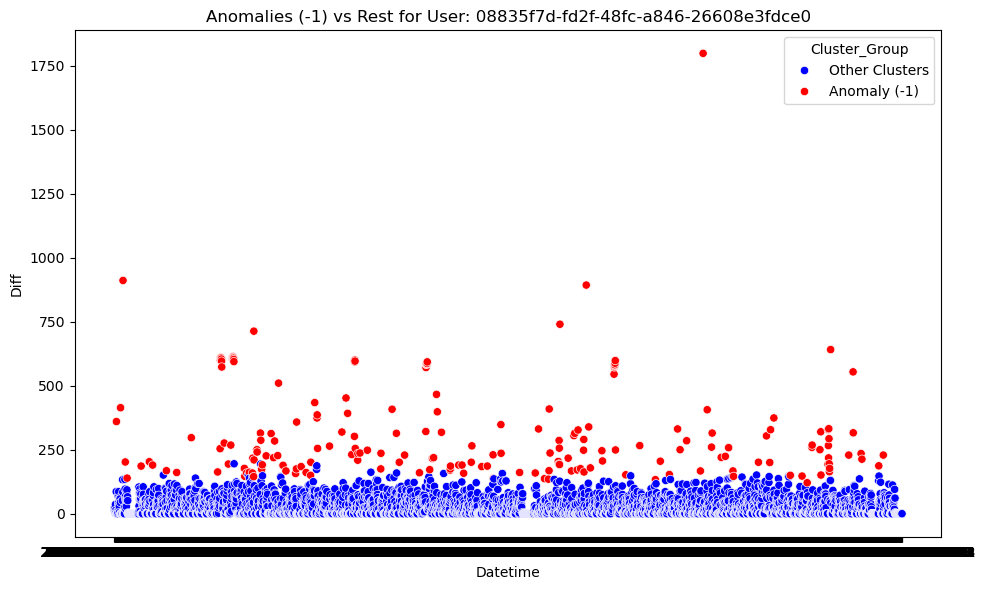

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

random_user = np.random.choice(df['user key'].unique())
user_df = df[df['user key'] == random_user].copy() #.head(100)
# Create a new column to distinguish anomalies vs rest
user_df['Cluster_Group'] = user_df['Cluster'].apply(lambda x: 'Anomaly (-1)' if x == -1 else 'Other Clusters')
# user_df  = user_df[user_df['diff']<10]  # Filter out large differences for better visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(data=user_df, x='datetime', y='diff', hue='Cluster_Group', palette={'Anomaly (-1)': 'red', 'Other Clusters': 'blue'}, legend='full')
plt.title(f'Anomalies (-1) vs Rest for User: {random_user}')
plt.xlabel('Datetime')
plt.ylabel('Diff')
plt.tight_layout()
plt.show()

In [6]:
# 🧬 Feature Engineering
conditions = [
    df['part_of_day_Afternoon'],
    df['part_of_day_Evening'],
    df['part_of_day_Morning'],
    df['part_of_day_Night']
]
choices = ['Afternoon', 'Evening', 'Morning', 'Night']
df['Part of Day'] = np.select(conditions, choices, default='Unknown')
df['Anomaly'] = np.where(df['Cluster'] == -1, 1, 0)

In [8]:
# 🔬 Scale Features
features = [
    'diff',
    'part_of_day_Afternoon', 'part_of_day_Evening', 'part_of_day_Morning', 'part_of_day_Night',
    'day_of_week_Friday', 'day_of_week_Monday', 'day_of_week_Saturday',
    'day_of_week_Sunday', 'day_of_week_Thursday', 'day_of_week_Tuesday', 'day_of_week_Wednesday'
]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])

In [9]:
# 🏗️ Train/Test Split & SMOTE
X_train, X_test, y_train, y_test, df_train, df_test = train_test_split(
    X_scaled,
    df['Anomaly'].values,
    df[['user key', 'datetime']],
    test_size=0.2,
    random_state=42
)
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [10]:
# 🚀 Train Logistic Regression
lr_model = LogisticRegression(max_iter=200)
lr_model.fit(X_train_res, y_train_res)
y_pred_lr = lr_model.predict(X_test)

In [11]:
# 💾 Save model & scaler
os.makedirs("./models/logisticRegression", exist_ok=True)
pickle.dump(lr_model, open("./models/logisticRegression/LogisticRegression.pkl", "wb"))
pickle.dump(scaler, open("./models/logisticRegression/standard_scaler.pkl", "wb"))

In [12]:
# Split your original DataFrame (with all columns)
df_train, df_test, y_train, y_test = train_test_split(
    df,
    df['Anomaly'].values,
    test_size=0.2,
    random_state=42
)

# Build a clean reference DataFrame for monitoring
reference_df = df_train[['meter reading', 'datetime', 'diff', 'part_of_day_Afternoon', 'part_of_day_Evening', 'part_of_day_Morning', 'part_of_day_Night', 'day_of_week_Friday', 'day_of_week_Monday', 'day_of_week_Saturday', 'day_of_week_Sunday', 'day_of_week_Thursday', 'day_of_week_Tuesday', 'day_of_week_Wednesday']].reset_index(drop=True)
reference_df['Anomaly'] = y_train
reference_df = df_train[features].reset_index(drop=True)
reference_df['Anomaly'] = y_train
reference_df.to_csv("./models/logisticRegression/reference_data.csv", index=False)

Accuracy: 0.9925
Precision: 0.4243
Recall: 0.9975
F1 Score: 0.5954


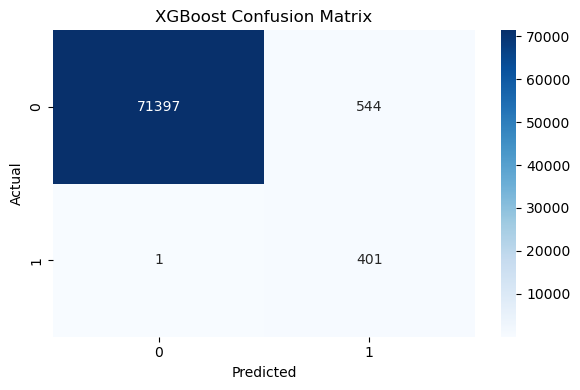

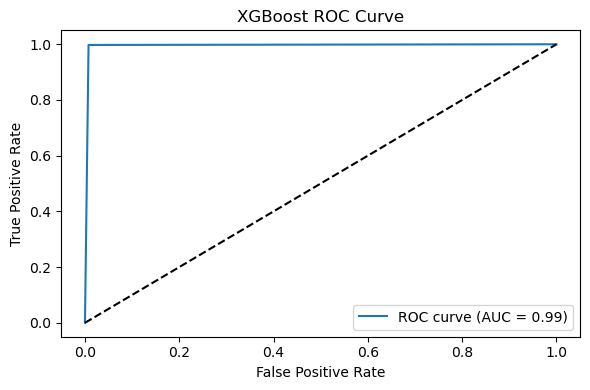

In [13]:
# Print evaluation scores
acc = accuracy_score(y_test, y_pred_lr)
prec = precision_score(y_test, y_pred_lr)
rec = recall_score(y_test, y_pred_lr)
f1 = f1_score(y_test, y_pred_lr)
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")

# Plot and show confusion matrix
cm = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("XGBoost Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Plot and show ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_lr)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost ROC Curve')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

In [16]:
# 🧩 MLflow PyFunc Wrapper
class LRModelWrapper(mlflow.pyfunc.PythonModel):
    def load_context(self, context):
        self.scaler = pickle.load(open("./models/logisticRegression/standard_scaler.pkl", "rb"))
        self.model = pickle.load(open("./models/logisticRegression/LogisticRegression.pkl", "rb"))

    def predict(self, context, model_input):
        meter_readings = np.array([x[0] for x in model_input])
        diffs = np.array([x[1] for x in model_input])
        timestamps = [x[2] for x in model_input]

        hours, weekdays = [], []
        for ts in timestamps:
            dt = pd.to_datetime(ts)
            hours.append(dt.hour)
            weekdays.append(dt.weekday())

        hours, weekdays = np.array(hours), np.array(weekdays)
        part_of_day = np.zeros((len(hours), 4))
        part_of_day[(5 <= hours) & (hours < 12), 0] = 1
        part_of_day[(12 <= hours) & (hours < 17), 1] = 1
        part_of_day[(17 <= hours) & (hours < 21), 2] = 1
        part_of_day[(hours >= 21) | (hours < 5), 3] = 1

        day_of_week = np.eye(7)[weekdays]
        features_input = np.column_stack((diffs, part_of_day, day_of_week))
        scaled = self.scaler.transform(features_input)
        preds = self.model.predict(scaled)
        return preds.tolist()

/opt/conda/lib/python3.11/site-packages/mlflow/pyfunc/utils/data_validation.py:186: UserWarning: Add type hints to the `predict` method to enable data validation and automatic signature inference during model logging. Check https://mlflow.org/docs/latest/model/python_model.html#type-hint-usage-in-pythonmodel for more details.
  color_warning(


In [17]:
# 🔍 Test wrapper
tester = LRModelWrapper()
tester.load_context(None)
sample_inputs = list(zip([1,100,10000,100000], [10,100,500,1000], df['datetime'].iloc[:4]))
predictions = tester.predict(None, sample_inputs)
print("Sample predictions:", predictions)

Sample predictions: [0, 0, 1, 1]


/opt/conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [21]:
def log_experiment():
    with mlflow.start_run():
        mlflow.log_param("model_type", "LogisticRegression")
        mlflow.log_param("max_iter", 200)
        mlflow.log_param("smote", True)

        mlflow.log_metric("accuracy", acc)
        mlflow.log_metric("precision", prec)
        mlflow.log_metric("recall", rec)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("roc_auc", roc_auc)

        plt.figure(figsize=(6,4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.title("Logistic Regression Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.tight_layout()
        plt.savefig("./models/logisticRegression/confusion_matrix.png")
        mlflow.log_artifact("./models/logisticRegression/confusion_matrix.png")

        mlflow.log_artifact("./models/logisticRegression/reference_data.csv")

        column_mapping = {
            "numerical_features": features,
            "categorical_features": [],
            "text_features": [],
            "input_features": features,
            "predicted_features": ["prediction"]
        }
        mlflow.log_param("column_mapping", json.dumps(column_mapping))

        signature = infer_signature(reference_df[features], lr_model.predict(scaler.transform(reference_df[features])))
        mlflow.pyfunc.log_model(
            artifact_path="model",
            python_model=LRModelWrapper(),
            artifacts={
                "standard_scaler": "./models/logisticRegression/standard_scaler.pkl",
                "model": "./models/logisticRegression/LogisticRegression.pkl"
            },
            registered_model_name="DemoLogisticRegression",
            signature=signature
        )

/opt/conda/lib/python3.11/site-packages/mlflow/pyfunc/__init__.py:3224: UserWarning: An input example was not provided when logging the model. To ensure the model signature functions correctly, specify the `input_example` parameter. See https://mlflow.org/docs/latest/model/signatures.html#model-input-example for more details about the benefits of using input_example.
  color_warning(


Registered model 'DemoLogisticRegression' already exists. Creating a new version of this model...
2025/07/18 08:46:49 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: DemoLogisticRegression, version 2
Created version '2' of model 'DemoLogisticRegression'.


🏃 View run masked-fly-63 at: http://10.149.59.75:5000/#/experiments/137/runs/4eddb0e54a8843588d4237e42baff5c0
🧪 View experiment at: http://10.149.59.75:5000/#/experiments/137


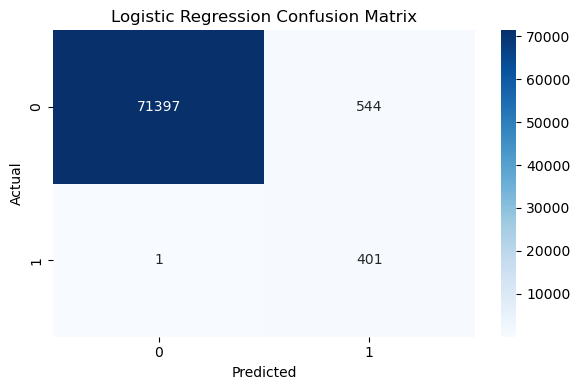

In [22]:
# ✅ Execute MLflow logging
if MLFLOW_LOGGING:
    log_experiment()

## Testing

In [ ]:
df[df["Anomaly"]==1]

In [ ]:
# 🔍 Test wrapper
tester = LRModelWrapper()
tester.load_context(None)
sample_inputs = list(zip(df['meter reading'].iloc[:5], df['diff'].iloc[:5], df['datetime'].iloc[:5]))
predictions = tester.predict(None, sample_inputs)
print("Sample predictions:", predictions)

In [ ]:
# 🔍 Test wrapper
tester = LRModelWrapper()
tester.load_context(None)
sample_inputs = list(zip([100,200,300,400,500], [1,100,10,3,50], df['datetime'].iloc[:5]))
predictions = tester.predict(None, sample_inputs)
print("Sample predictions:", predictions)